In [ ]:
!pip install tensorflow

In [ ]:
!pip install gdown

#Import Library

In [1]:
import os
import cv2
import numpy as np
import xml.etree.ElementTree as ET
from PIL import Image, UnidentifiedImageError
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import glob
from tqdm import tqdm
import gdown
import pickle

In [ ]:
!nvidia-smi

Fri Nov 14 04:15:04 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.65.05              Driver Version: 580.88         CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060        On  |   00000000:01:00.0  On |                  N/A |
|  0%   56C    P0            N/A  /  115W |    1259MiB /   8188MiB |     16%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

#Download Dataset

In [ ]:
if not os.path.exists('./dataset.zip'):
  gdown.download('https://drive.google.com/file/d/1eXEjQB68y_zzrUGSQ-2p6ZDGdmpJ1ypy/view?usp=sharing', './dataset.zip', fuzzy=True)


In [ ]:
if not os.path.exists('./dataset'):
    !unzip -q dataset.zip -d dataset

In [ ]:
root_dir = './dataset'

#Dataset preparing
ทำการโหลก annotation ที่มีใน dataset และนำมา match กับรูปภาพ
จากนั้น save cache เป็น pickle เพื่อที่เวลารันใน colab ครั้งแรกจะไม่ต้องรอนาน

In [ ]:
# Function to parse XML annotation and extract bounding box
def parse_xml_annotation(xml_path):
    """
    Parse XML annotation file and extract image filename, bounding box coordinates, and label.

    Args:
        xml_path: Path to the XML annotation file

    Returns:
        dict with 'filename', 'bbox' (xmin, ymin, xmax, ymax), and 'label'
    """
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()

        # Extract filename
        filename = root.find('filename').text

        # Extract bounding box
        obj = root.find('object')
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)

        # Extract label (class name)
        label = obj.find('name').text

        return {
            'filename': filename,
            'bbox': (xmin, ymin, xmax, ymax),
            'label': label
        }
    except Exception as e:
        print(f"Error parsing {xml_path}: {e}")
        return None

# Load all XML annotations and collect dataset information
def load_dataset_from_xml(root_dir):
    """
    Load all XML annotations from the dataset directory structure.

    Args:
        root_dir: Root directory containing Training set and Test set folders

    Returns:
        List of dictionaries containing image paths, bboxes, and labels
    """
    cache_path = os.path.join(root_dir, '_cached_data.pkl')

    if os.path.exists(cache_path):
        print(f"Loading data from cache: {cache_path}")
        with open(cache_path, 'rb') as f:
            data_list, unique_labels = pickle.load(f)
        print(f"Successfully loaded {len(data_list)} annotations from cache")
        print(f"Found {len(unique_labels)} unique classes: {unique_labels}")
        return data_list, unique_labels

    print(f"Cache not found, loading data from XML files in {root_dir}...")
    data_list = []

    # Search for all XML files in the directory structure
    xml_files = glob.glob(os.path.join(root_dir, "**", "*.xml"), recursive=True)

    print(f"Found {len(xml_files)} XML annotation files")

    for xml_path in tqdm(xml_files, desc="Loading annotations"):
        annotation = parse_xml_annotation(xml_path)

        if annotation is not None:
            xml_dir = os.path.dirname(xml_path)
            parent_dir = os.path.dirname(xml_dir)

            found_image = False
            for ext in ['.jpg', '.jpeg', '.png', '.JPG', '.JPEG']:
                base_img_filename = os.path.splitext(annotation['filename'])[0]
                img_filename_with_ext = base_img_filename + ext

                img_path = os.path.join(parent_dir, "Images (JPEG)", img_filename_with_ext)

                if os.path.exists(img_path):
                    annotation['image_path'] = img_path
                    data_list.append(annotation)
                    found_image = True
                    break

            if not found_image:
                for ext in ['.jpg', '.jpeg', '.png', '.JPG', '.JPEG']:
                    base_img_filename = os.path.splitext(annotation['filename'])[0]
                    img_filename_with_ext = base_img_filename + ext
                    search_path = os.path.join(parent_dir, "**", img_filename_with_ext)
                    matches = glob.glob(search_path, recursive=True)
                    if matches:
                        annotation['image_path'] = matches[0]
                        data_list.append(annotation)
                        found_image = True
                        break

            if not found_image:
                print(f"Warning: Could not find image for {annotation['filename']} from {xml_path}")

    print(f"Successfully loaded {len(data_list)} annotations with valid image paths")

    # Get unique labels
    unique_labels = sorted(list(set([item['label'] for item in data_list])))
    print(f"Found {len(unique_labels)} unique classes: {unique_labels}")

    # Save to cache
    with open(cache_path, 'wb') as f:
        pickle.dump((data_list, unique_labels), f)
    print(f"Data saved to cache: {cache_path}")

    return data_list, unique_labels

# Load dataset
train_dir = os.path.join(root_dir, "Training set")
test_dir = os.path.join(root_dir, "Test set")

print("Loading training data...")
train_data, class_names = load_dataset_from_xml(train_dir)

print("\nLoading test data...")
test_data, _ = load_dataset_from_xml(test_dir)

print(f"\nTotal training samples: {len(train_data)}")
print(f"Total test samples: {len(test_data)}")
print(f"Classes: {class_names}")

Loading training data...
Loading data from cache: ./dataset/Training set/_cached_data.pkl
Successfully loaded 5760 annotations from cache
Found 15 unique classes: ['bor', 'dor', 'for', 'hor', 'ko', 'lor', 'mor', 'nor', 'or', 'por', 'rao', 'sor', 'tor', 'wor', 'yor']

Loading test data...
Loading data from cache: ./dataset/Test set/_cached_data.pkl
Successfully loaded 1440 annotations from cache
Found 15 unique classes: ['bor', 'dor', 'for', 'hor', 'ko', 'lor', 'mor', 'nor', 'or', 'por', 'rao', 'sor', 'tor', 'wor', 'yor']

Total training samples: 5760
Total test samples: 1440
Classes: ['bor', 'dor', 'for', 'hor', 'ko', 'lor', 'mor', 'nor', 'or', 'por', 'rao', 'sor', 'tor', 'wor', 'yor']


#Preprocessing (hand detection + crop)

Sample cropped images:


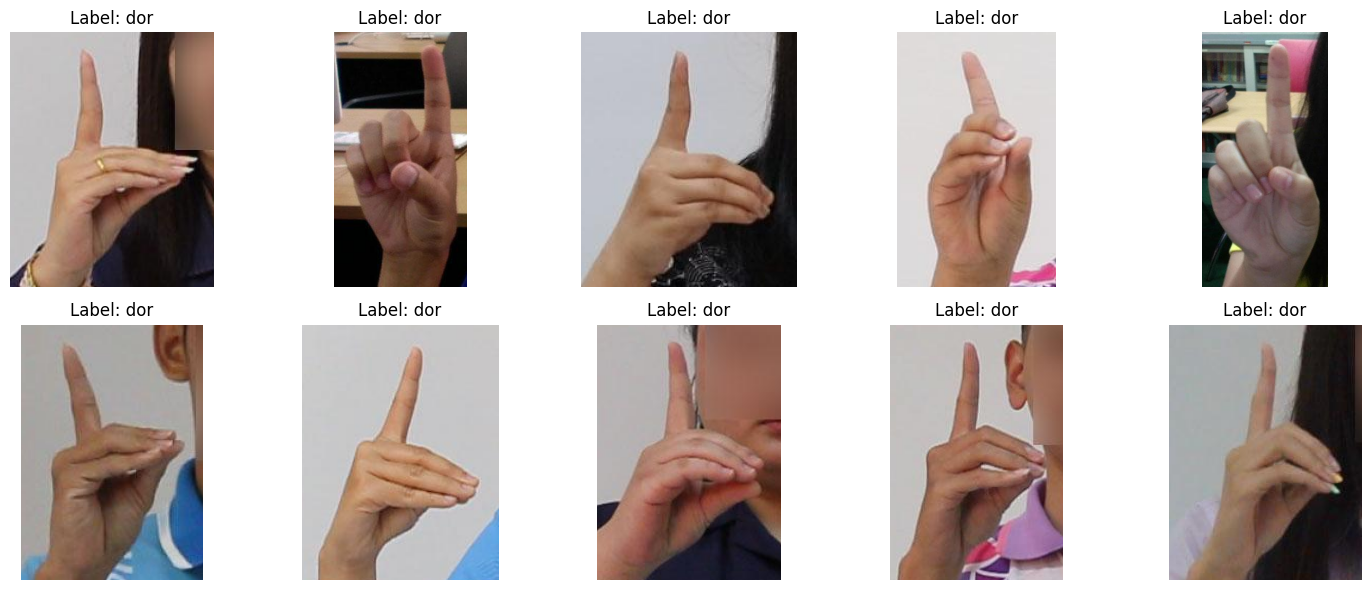

In [ ]:
# crop image using bounding box
def crop_image_with_bbox(image_path, bbox, margin=10):
    try:
        img = cv2.imread(image_path)
        if img is None:
            return None

        h, w, _ = img.shape
        xmin, ymin, xmax, ymax = bbox

        xmin = max(0, xmin - margin)
        ymin = max(0, ymin - margin)
        xmax = min(w, xmax + margin)
        ymax = min(h, ymax + margin)

        cropped = img[ymin:ymax, xmin:xmax]

        return cropped
    except Exception as e:
        print(f"Error cropping image {image_path}: {e}")
        return None

# Visualize
print("Sample cropped images:")
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i in range(min(10, len(train_data))):
    sample = train_data[i]
    cropped = crop_image_with_bbox(sample['image_path'], sample['bbox'])

    if cropped is not None:
        cropped_rgb = cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB)
        axes[i].imshow(cropped_rgb)
        axes[i].set_title(f"Label: {sample['label']}")
        axes[i].axis('off')

plt.tight_layout()
plt.show()

###Class ในการทำ augmentation
การหมุนภาพ ปรับแสงและ contrast

In [ ]:
# Custom data generator
class CroppedSignDataGenerator(keras.utils.Sequence):
    """
    Custom Keras Sequence that loads images, crops them using bounding boxes,
    and applies transformations.
    """
    def __init__(self, data_list, class_names, batch_size=32, shuffle=True, margin=10, augment=False, target_size=(224, 224)):
        self.data_list = data_list
        self.class_names = class_names
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.margin = margin
        self.augment = augment
        self.target_size = target_size

        # Create label to index mapping
        self.label_to_idx = {label: idx for idx, label in enumerate(class_names)}
        self.indexes = np.arange(len(self.data_list))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.data_list) / self.batch_size))

    def __getitem__(self, index):
        # Generate indexes of the batch
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Generate data
        X, y = self._generate_data(batch_indexes)

        return X, y

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def _apply_augmentation(self, image):
        """Apply random augmentations to normalized image"""
        # Random rotation
        if np.random.rand() > 0.5:
            angle = np.random.uniform(-40, 40)
            h, w = image.shape[:2]
            M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1.0)
            image = cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_REFLECT)

        # Random brightness
        if np.random.rand() > 0.5:
            brightness = np.random.uniform(0.8, 1.2)
            image = np.clip(image * brightness, -4.0, 4.0)

        # Random contrast
        if np.random.rand() > 0.5:
            contrast = np.random.uniform(0.8, 1.2)
            mean = np.mean(image)
            image = np.clip((image - mean) * contrast + mean, -3.0, 3.0)

        return image


    def _generate_data(self, batch_indexes):
        """Generates data containing batch_size samples"""
        X = np.empty((len(batch_indexes), *self.target_size, 3), dtype=np.float32)
        y = np.empty((len(batch_indexes)), dtype=int)

        for i, idx in enumerate(batch_indexes):
            sample = self.data_list[idx]

            # Crop image using bounding box
            cropped_img = crop_image_with_bbox(sample['image_path'], sample['bbox'], self.margin)

            if cropped_img is None:
                # Return blank image if cropping fails
                cropped_img = np.zeros((*self.target_size, 3), dtype=np.uint8)

            # Convert BGR to RGB
            cropped_img = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)

            # Resize image
            cropped_img = cv2.resize(cropped_img, self.target_size)

            # Normalize to [0, 1]
            cropped_img = cropped_img.astype(np.float32) / 255.0

            # Apply ImageNet normalization
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            cropped_img = (cropped_img - mean) / std

            if self.augment:
              cropped_img = self._apply_augmentation(cropped_img)

            X[i] = cropped_img
            y[i] = self.label_to_idx[sample['label']]

        return X, keras.utils.to_categorical(y, num_classes=len(self.class_names))

print("Custom data generator class created successfully!")

Custom data generator class created successfully!


#Data augmentation

###ทำ training และ validation data generator

In [ ]:
# Create data generators with and without augmentation
batch_size = 32

# Training generator with augmentation
train_generator = CroppedSignDataGenerator(
    train_data,
    class_names,
    batch_size=batch_size,
    shuffle=True,
    margin=10,
    augment=True,
    target_size=(224, 224)
)

# Validation generator without augmentation
val_generator = CroppedSignDataGenerator(
    test_data,
    class_names,
    batch_size=batch_size,
    shuffle=False,
    margin=10,
    augment=False,
    target_size=(224, 224)
)

print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(test_data)}")
print(f"Number of classes: {len(class_names)}")
print(f"Batch size: {batch_size}")
print(f"Training batches: {len(train_generator)}")
print(f"Validation batches: {len(val_generator)}")

Training samples: 5760
Validation samples: 1440
Number of classes: 15
Batch size: 32
Training batches: 180
Validation batches: 45


###แสดงภาพหลังจากการทำ augmentation

Training samples:


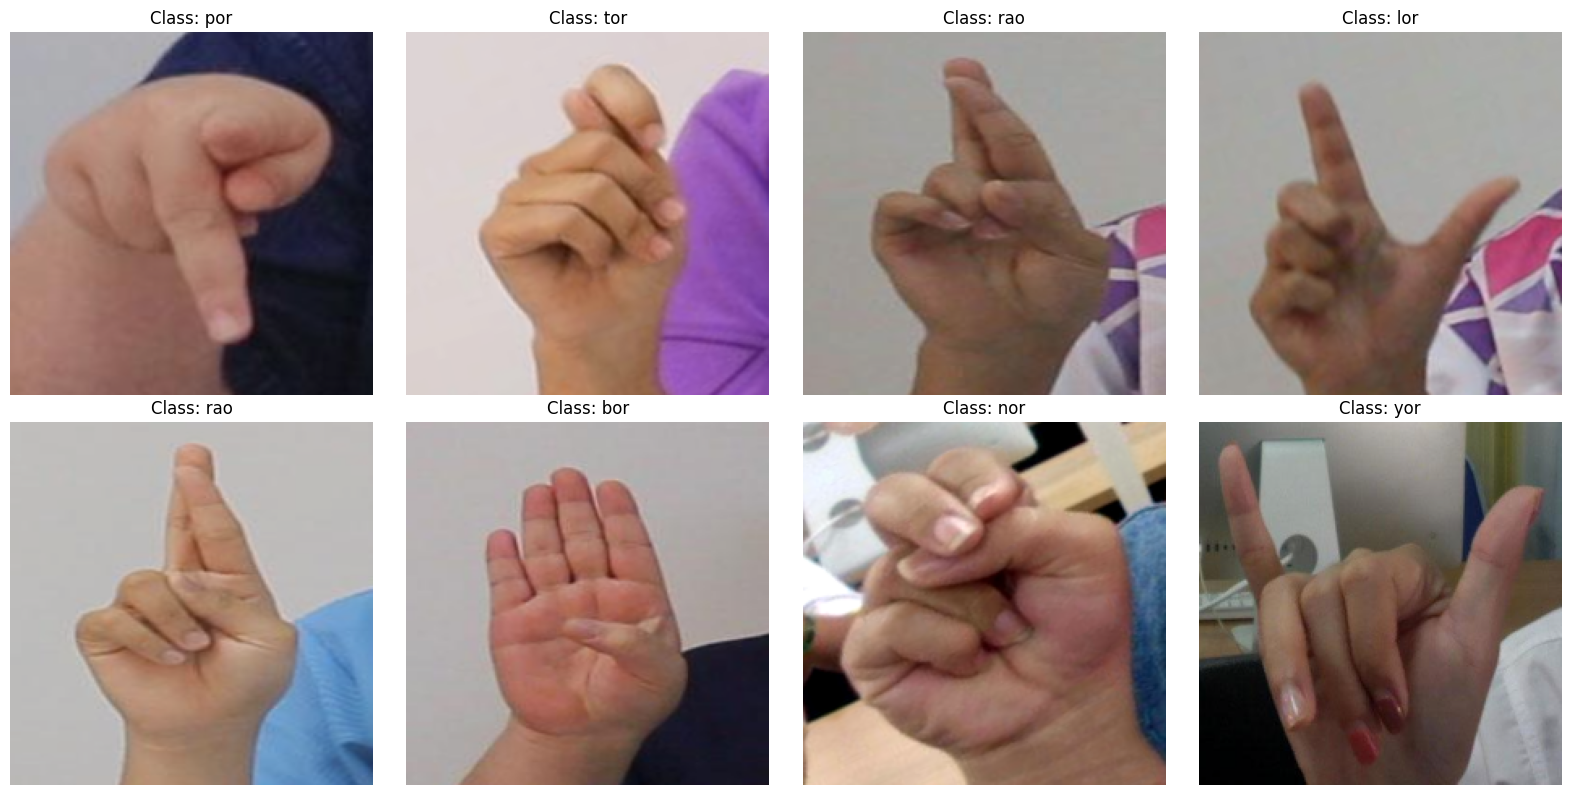

In [ ]:
# Visualize augmented samples
def show_augmented_samples(generator, class_names, num_samples=8):
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()

    # Get a batch
    X_batch, y_batch = generator[0]

    for i in range(min(num_samples, len(X_batch))):
        img = X_batch[i]
        label_idx = np.argmax(y_batch[i])

        # Denormalize image for visualization
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img_display = img * std + mean
        img_display = np.clip(img_display, 0, 1)

        axes[i].imshow(img_display)
        axes[i].set_title(f"Class: {class_names[label_idx]}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

print("Training samples:")
show_augmented_samples(train_generator, class_names)

#Train

โหลด Pre-trained model ของ MobileNetV2

In [ ]:
def build_mobilenet_classifier(num_classes, input_shape=(224, 224, 3)):
    # Load pretrained MobileNetV2
    base_model = MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet',
        pooling='avg'
    )

    # Build the model
    inputs = keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs, outputs)

    return model

# directory to save model outputs
model_output_dir = os.path.join(root_dir, "model")
os.makedirs(model_output_dir, exist_ok=True)
print(f"Model outputs will be saved to: {model_output_dir}")

# Initialize model
num_classes = len(class_names)
model = build_mobilenet_classifier(num_classes)

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"Model initialized with {num_classes} output classes")
print(f"Total parameters: {model.count_params():,}")
model.summary()

Model outputs will be saved to: ./dataset/model
Model initialized with 15 output classes
Total parameters: 2,277,199


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │        19,215 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,277,199 (8.69 MB)

 Trainable params: 2,243,087 (8.56 MB)

 Non-trainable params: 34,112 (133.25 KB)

กำหนด output path,early stopping และ ลด learning rate ถ้าจำเป็น

In [ ]:
# Setup callbacks for training
num_epochs = 50
patience_es = 5
min_delta_es = 0.001

# Define callbacks
callbacks = [
    # Save best model
    ModelCheckpoint(
        filepath=os.path.join(model_output_dir, "best_sign_model.h5"),
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    # Early stopping
    EarlyStopping(
        monitor='val_loss',
        patience=patience_es,
        min_delta=min_delta_es,
        restore_best_weights=True,
        verbose=1
    ),
    # Reduce learning rate on plateau
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

print("Callbacks configured successfully!")
print(f"- Best model will be saved to: {os.path.join(model_output_dir, 'best_sign_model.h5')}")
print(f"- Early stopping: patience={patience_es}, min_delta={min_delta_es}")
print(f"- Learning rate reduction on plateau")

Callbacks configured successfully!
- Best model will be saved to: ./dataset/model/best_sign_model.h5
- Early stopping: patience=5, min_delta=0.001
- Learning rate reduction on plateau


###Train model

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=num_epochs,
    callbacks=callbacks,
    verbose=1
)

# Save final model
model.save(os.path.join(model_output_dir, "final_sign_model.h5"))
print("\n✅ Training completed! Final model saved.")

Epoch 1/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.5460 - loss: 1.5224
Epoch 1: val_accuracy improved from -inf to 0.64375, saving model to ./dataset/model/best_sign_model.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 77s 226ms/step - accuracy: 0.5471 - loss: 1.5186 - val_accuracy: 0.6438 - val_loss: 1.0094 - learning_rate: 1.0000e-04
Epoch 2/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9510 - loss: 0.1743
Epoch 2: val_accuracy improved from 0.64375 to 0.75417, saving model to ./dataset/model/best_sign_model.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 31s 170ms/step - accuracy: 0.9510 - loss: 0.1742 - val_accuracy: 0.7542 - val_loss: 0.6786 - learning_rate: 1.0000e-04
Epoch 3/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9806 - loss: 0.0741
Epoch 3: val_accuracy improved from 0.75417 to 0.90556, saving model to ./dataset/model/best_sign_model.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 30s 167ms/step - accuracy: 0.9806 - loss: 0.0741 - val_accuracy: 0.9056 - val_loss: 0.2753 - learning_rate: 1.0000e-04
Epoch 4/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9842 - loss: 0.0511
Epoch 4: val_accuracy improved from 0.90556 to 0.93333, saving model to ./dataset/model/best_sign_model.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 29s 162ms/step - accuracy: 0.9842 - loss: 0.0511 - val_accuracy: 0.9333 - val_loss: 0.1949 - learning_rate: 1.0000e-04
Epoch 5/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9902 - loss: 0.0393
Epoch 5: val_accuracy improved from 0.93333 to 0.93889, saving model to ./dataset/model/best_sign_model.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 30s 163ms/step - accuracy: 0.9902 - loss: 0.0393 - val_accuracy: 0.9389 - val_loss: 0.1639 - learning_rate: 1.0000e-04
Epoch 6/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9898 - loss: 0.0325
Epoch 6: val_accuracy improved from 0.93889 to 0.95972, saving model to ./dataset/model/best_sign_model.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 31s 172ms/step - accuracy: 0.9898 - loss: 0.0325 - val_accuracy: 0.9597 - val_loss: 0.1346 - learning_rate: 1.0000e-04
Epoch 7/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9947 - loss: 0.0218
Epoch 7: val_accuracy did not improve from 0.95972
180/180 ━━━━━━━━━━━━━━━━━━━━ 31s 173ms/step - accuracy: 0.9947 - loss: 0.0218 - val_accuracy: 0.9507 - val_loss: 0.1708 - learning_rate: 1.0000e-04
Epoch 8/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9966 - loss: 0.0143
Epoch 8: val_accuracy improved from 0.95972 to 0.98611, saving model to ./dataset/model/best_sign_model.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 30s 167ms/step - accuracy: 0.9966 - loss: 0.0143 - val_accuracy: 0.9861 - val_loss: 0.0567 - learning_rate: 1.0000e-04
Epoch 9/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9956 - loss: 0.0150
Epoch 9: val_accuracy did not improve from 0.98611
180/180 ━━━━━━━━━━━━━━━━━━━━ 30s 164ms/step - accuracy: 0.9956 - loss: 0.0150 - val_accuracy: 0.9785 - val_loss: 0.0664 - learning_rate: 1.0000e-04
Epoch 10/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9955 - loss: 0.0158
Epoch 10: val_accuracy did not improve from 0.98611
180/180 ━━━━━━━━━━━━━━━━━━━━ 29s 161ms/step - accuracy: 0.9955 - loss: 0.0158 - val_accuracy: 0.9854 - val_loss: 0.0509 - learning_rate: 1.0000e-04
Epoch 11/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9931 - loss: 0.0211
Epoch 11: val_accuracy did not improve from 0.98611
180/180 ━━━━━━━━━━━━━━━━━━━━ 29s 160ms/step - accuracy: 0.9931 - loss: 0.0211 - val_accuracy: 0.9785 - val_loss: 0.0839 - learning_rate

180/180 ━━━━━━━━━━━━━━━━━━━━ 31s 174ms/step - accuracy: 0.9953 - loss: 0.0144 - val_accuracy: 0.9882 - val_loss: 0.0486 - learning_rate: 1.0000e-04
Epoch 15/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9978 - loss: 0.0082
Epoch 15: val_accuracy did not improve from 0.98819
180/180 ━━━━━━━━━━━━━━━━━━━━ 29s 161ms/step - accuracy: 0.9978 - loss: 0.0083 - val_accuracy: 0.9847 - val_loss: 0.0429 - learning_rate: 1.0000e-04
Epoch 16/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9939 - loss: 0.0170
Epoch 16: val_accuracy did not improve from 0.98819
180/180 ━━━━━━━━━━━━━━━━━━━━ 29s 162ms/step - accuracy: 0.9939 - loss: 0.0170 - val_accuracy: 0.9833 - val_loss: 0.0488 - learning_rate: 1.0000e-04
Epoch 17/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9976 - loss: 0.0085
Epoch 17: val_accuracy did not improve from 0.98819
180/180 ━━━━━━━━━━━━━━━━━━━━ 29s 159ms/step - accuracy: 0.9976 - loss: 0.0085 - val_accuracy: 0.9778 - val_loss: 0.0828 - learning_ra


✅ Training completed! Final model saved.


บันทึก training history

In [ ]:
import pickle

# Save training history to pickle file
history_path = os.path.join(model_output_dir, "training_history.pkl")
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f)
print(f"✅ Training history saved to: {history_path}")

# Also save important training metadata
training_metadata = {
    'num_epochs_trained': len(history.history['loss']),
    'batch_size': batch_size,
    'num_classes': num_classes,
    'class_names': class_names,
    'train_samples': len(train_data),
    'val_samples': len(test_data),
    'best_val_accuracy': max(history.history['val_accuracy']),
    'best_val_loss': min(history.history['val_loss']),
    'final_train_accuracy': history.history['accuracy'][-1],
    'final_val_accuracy': history.history['val_accuracy'][-1]
}

metadata_path = os.path.join(model_output_dir, "training_metadata.pkl")
with open(metadata_path, 'wb') as f:
    pickle.dump(training_metadata, f)
print(f"✅ Training metadata saved to: {metadata_path}")

✅ Training history saved to: ./dataset/model/training_history.pkl
✅ Training metadata saved to: ./dataset/model/training_metadata.pkl


###Plot graph แสดง accuracy และ loss ของการ training และ validation

📊 Training curves saved to './dataset/model/training_curves.png'


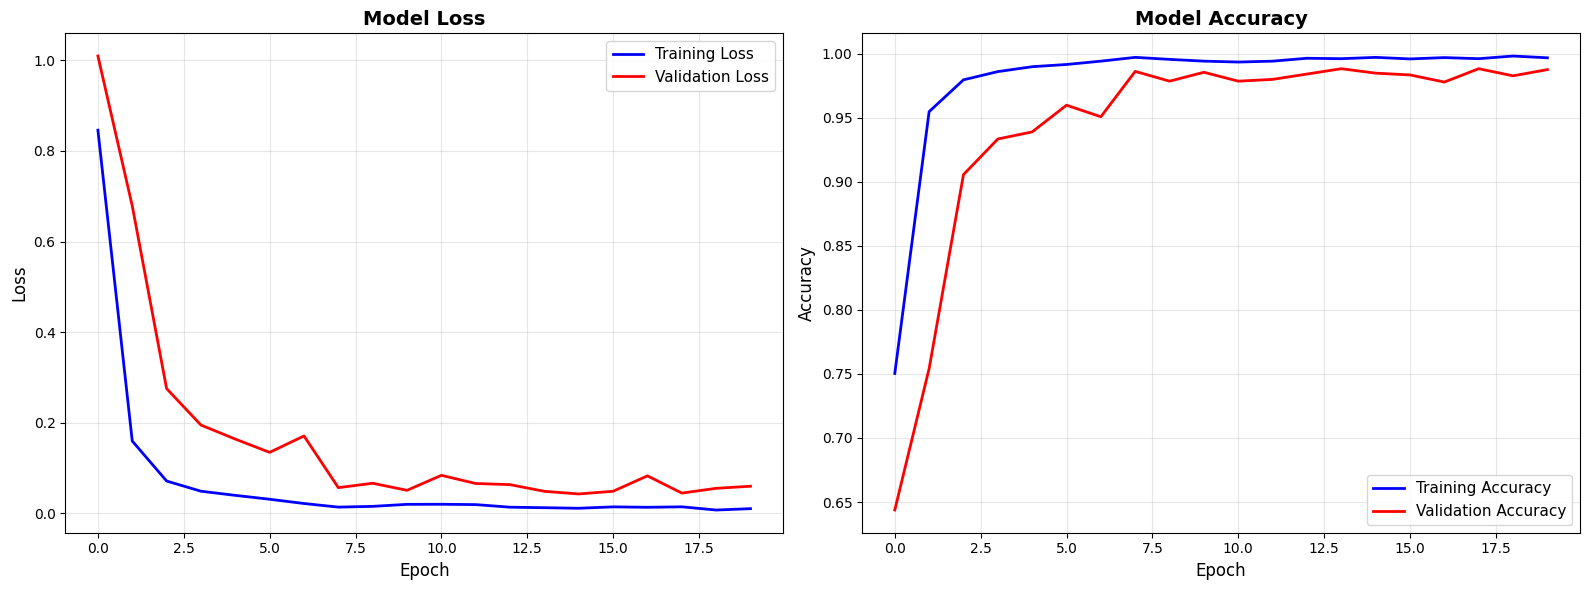

In [ ]:
def plot_training_history(history, model_save_dir="model"):
    """
    Plot training and validation loss and accuracy curves.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Plot loss
    ax1.plot(history.history['loss'], 'b-', label='Training Loss', linewidth=2)
    ax1.plot(history.history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    ax1.set_title('Model Loss', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)

    # Plot accuracy
    ax2.plot(history.history['accuracy'], 'b-', label='Training Accuracy', linewidth=2)
    ax2.plot(history.history['val_accuracy'], 'r-', label='Validation Accuracy', linewidth=2)
    ax2.set_title('Model Accuracy', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()

    # Save figure to model folder
    os.makedirs(model_save_dir, exist_ok=True)
    plt.savefig(os.path.join(model_save_dir, "training_curves.png"), dpi=150, bbox_inches='tight')
    print(f"📊 Training curves saved to '{os.path.join(model_save_dir, "training_curves.png")}'")
    plt.show()

plot_training_history(history, model_save_dir=model_output_dir)

#Evaluation

โหลด model ที่เคย save ไว้ (ใช้ตอนเมื่อไม่ได้ train ใน session นั้นๆ)

In [1]:
root_dir = "./dataset"
model_output_dir = os.path.join(root_dir, "model")

print("="*60)
print("LOADING SAVED MODEL AND RESULTS")
print("="*60)

# Load the best trained model
model_path = os.path.join(model_output_dir, "best_sign_model.h5")
if os.path.exists(model_path):
    model = keras.models.load_model(model_path)
    print(f"✅ Model loaded from: {model_path}")
else:
    print(f"❌ Model not found at: {model_path}")
    print("   Please train the model first!")

# Load training history
history_path = os.path.join(model_output_dir, "training_history.pkl")
if os.path.exists(history_path):
    with open(history_path, 'rb') as f:
        history_dict = pickle.load(f)

    class History:
        def __init__(self, history_dict):
            self.history = history_dict

    history = History(history_dict)
    print(f"✅ Training history loaded from: {history_path}")
    print(f"   Epochs trained: {len(history_dict['loss'])}")
    print(f"   Best val accuracy: {max(history_dict['val_accuracy']):.4f}")
else:
    print(f"⚠️  Training history not found at: {history_path}")
    history = None

# Load training metadata
metadata_path = os.path.join(model_output_dir, "training_metadata.pkl")
if os.path.exists(metadata_path):
    with open(metadata_path, 'rb') as f:
        training_metadata = pickle.load(f)
    print(f"✅ Training metadata loaded from: {metadata_path}")

    class_names = training_metadata['class_names']
    num_classes = training_metadata['num_classes']
    batch_size = training_metadata.get('batch_size', 32)

    print(f"   Classes: {class_names}")
    print(f"   Number of classes: {num_classes}")
else:
    print(f"⚠️  Training metadata not found at: {metadata_path}")
    class_names = ['bor', 'dor', 'for', 'hor', 'ko', 'lor', 'mor', 'nor', 'or', 'por', 'rao', 'sor', 'tor', 'wor', 'yor']
    num_classes = len(class_names)

# Load evaluation results
eval_path = os.path.join(model_output_dir, "evaluation_results.pkl")
if os.path.exists(eval_path):
    with open(eval_path, 'rb') as f:
        eval_results = pickle.load(f)

    val_loss = eval_results['val_loss']
    val_acc = eval_results['val_accuracy']
    val_preds = eval_results['val_predictions']
    val_labels = eval_results['val_labels']

    print(f"✅ Evaluation results loaded from: {eval_path}")
    print(f"   Validation accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")
    print(f"   Validation loss: {val_loss:.4f}")
else:
    print(f"⚠️  Evaluation results not found at: {eval_path}")
    print("   You can run evaluation cells to generate new results")

/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.7.1, so it will not be used.
  warnings.warn(


LOADING SAVED MODEL AND RESULTS


✅ Model loaded from: ./dataset/model/best_sign_model.h5
✅ Training history loaded from: ./dataset/model/training_history.pkl
   Epochs trained: 20
   Best val accuracy: 0.9882
✅ Training metadata loaded from: ./dataset/model/training_metadata.pkl
   Classes: ['bor', 'dor', 'for', 'hor', 'ko', 'lor', 'mor', 'nor', 'or', 'por', 'rao', 'sor', 'tor', 'wor', 'yor']
   Number of classes: 15
✅ Evaluation results loaded from: ./dataset/model/evaluation_results.pkl
   Validation accuracy: 0.9882 (98.82%)
   Validation loss: 0.0486


In [ ]:
# Load best model for evaluation
model = keras.models.load_model(os.path.join(model_output_dir, "best_sign_model.h5"))
print("✅ Loaded best model for evaluation")

✅ Loaded best model for evaluation


###Evaluate validation set

In [ ]:
# Evaluate on validation set
def evaluate_model(model, data_generator):
    """
    Evaluate model and return loss, accuracy, predictions, and labels.
    """
    all_preds = []
    all_labels = []

    print("Evaluating model...")
    for i in tqdm(range(len(data_generator))):
        X_batch, y_batch = data_generator[i]

        # Make predictions
        predictions = model.predict(X_batch, verbose=0)
        pred_classes = np.argmax(predictions, axis=1)
        true_classes = np.argmax(y_batch, axis=1)

        all_preds.extend(pred_classes)
        all_labels.extend(true_classes)

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Calculate accuracy
    accuracy = np.mean(all_preds == all_labels)

    return accuracy, all_preds, all_labels

# Evaluate on validation set
val_loss, val_acc = model.evaluate(val_generator, verbose=1)
_, val_preds, val_labels = evaluate_model(model, val_generator)

print(f"\n{'='*50}")
print(f"Validation Results:")
print(f"{'='*50}")
print(f"Loss: {val_loss:.4f}")
print(f"Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")
print(f"{'='*50}")

45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - accuracy: 0.9903 - loss: 0.0341
Evaluating model...


100%|██████████| 45/45 [00:14<00:00,  3.21it/s]


Validation Results:
Loss: 0.0486
Accuracy: 0.9882 (98.82%)


In [ ]:
# Save evaluation metrics
eval_results = {
    'val_loss': val_loss,
    'val_accuracy': val_acc,
    'val_predictions': val_preds,
    'val_labels': val_labels
}

eval_path = os.path.join(model_output_dir, "evaluation_results.pkl")
with open(eval_path, 'wb') as f:
    pickle.dump(eval_results, f)
print(f"✅ Evaluation results saved to: {eval_path}")

✅ Evaluation results saved to: ./dataset/model/evaluation_results.pkl


###สร้าง confusion matrix

📊 Confusion matrix saved to: ./dataset/model/evaluation/confusion_matrix.png


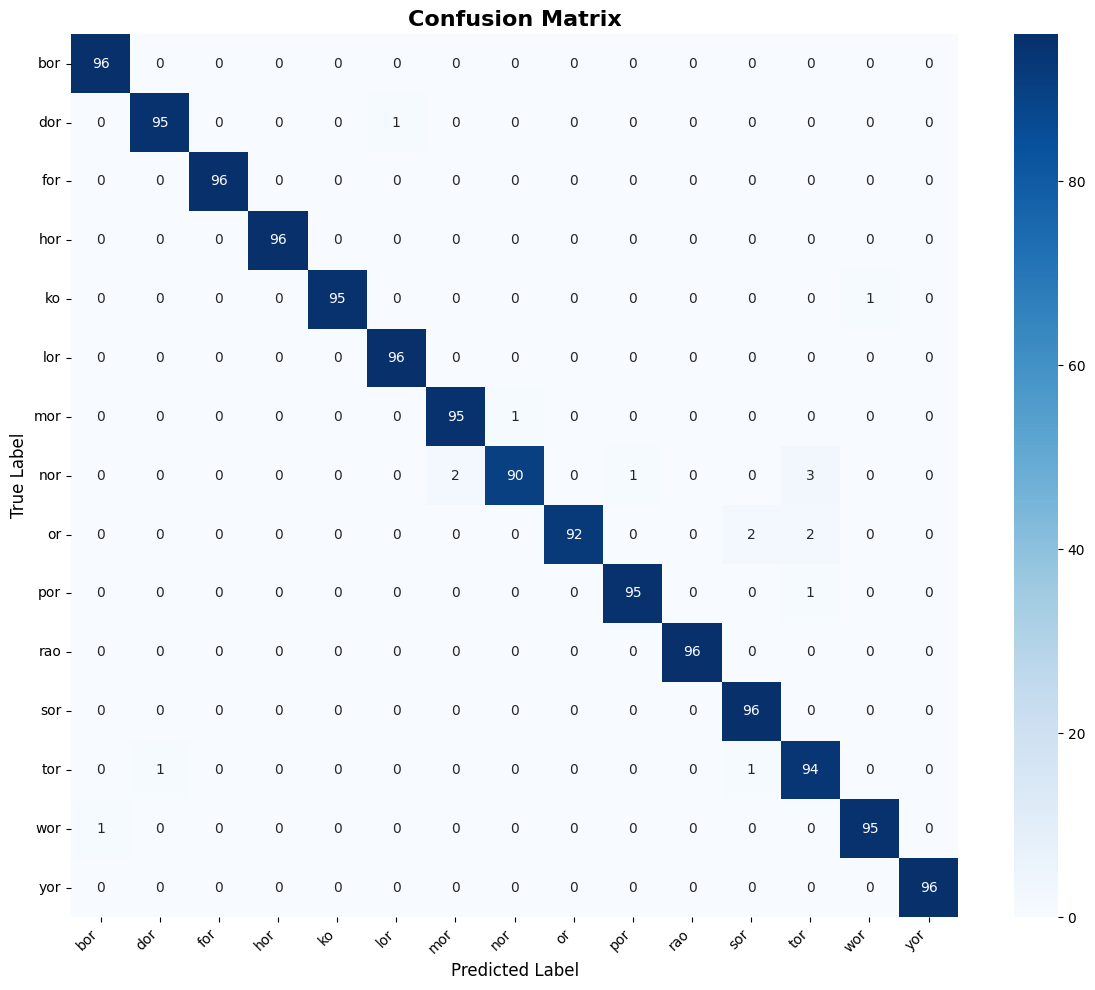


CLASSIFICATION REPORT
              precision    recall  f1-score   support

         bor     0.9897    1.0000    0.9948        96
         dor     0.9896    0.9896    0.9896        96
         for     1.0000    1.0000    1.0000        96
         hor     1.0000    1.0000    1.0000        96
          ko     1.0000    0.9896    0.9948        96
         lor     0.9897    1.0000    0.9948        96
         mor     0.9794    0.9896    0.9845        96
         nor     0.9890    0.9375    0.9626        96
          or     1.0000    0.9583    0.9787        96
         por     0.9896    0.9896    0.9896        96
         rao     1.0000    1.0000    1.0000        96
         sor     0.9697    1.0000    0.9846        96
         tor     0.9400    0.9792    0.9592        96
         wor     0.9896    0.9896    0.9896        96
         yor     1.0000    1.0000    1.0000        96

    accuracy                         0.9882      1440
   macro avg     0.9884    0.9882    0.9882      1440
wei

In [ ]:
eval_dir = os.path.join(model_output_dir, "evaluation")
os.makedirs(eval_dir, exist_ok=True)

# Generate and save confusion matrix
cm = confusion_matrix(val_labels, val_preds)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

cm_path = os.path.join(eval_dir, "confusion_matrix.png")
plt.savefig(cm_path, dpi=150, bbox_inches='tight')
print(f"📊 Confusion matrix saved to: {cm_path}")
plt.show()

# Generate and save classification report
report = classification_report(val_labels, val_preds, target_names=class_names, digits=4)
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(report)

report_path = os.path.join(eval_dir, "classification_report.txt")
with open(report_path, 'w', encoding='utf-8') as f:
    f.write("CLASSIFICATION REPORT\n")
    f.write("="*60 + "\n")
    f.write(report)
print(f"✅ Classification report saved to: {report_path}")

#Summary

In [ ]:
print("\n" + "="*60)
print("TRAINING AND EVALUATION SUMMARY")
print("="*60)
print(f"Dataset:")
print(f"  - Training samples: {len(train_data)}")
print(f"  - Validation samples: {len(test_data)}")
print(f"  - Number of classes: {len(class_names)}")
print(f"\nModel:")
print(f"  - Architecture: MobileNetV2")
print(f"  - Input size: 224x224")
print(f"\nTraining:")
print(f"  - Epochs: {len(history.history['loss'])}")
print(f"  - Batch size: {batch_size}")
print(f"  - Optimizer: Adam (lr=1e-4)")
print(f"  - Best validation accuracy: {max(history.history['val_accuracy']):.4f}")
print(f"\nFinal Validation Results:")
print(f"  - Loss: {val_loss:.4f}")
print(f"  - Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")
print(f"\nSaved Files:")
print(f"  Model outputs (saved to {model_output_dir}):")
print(f"    - best_sign_model.h5 (best model)")
print(f"    - final_sign_model.h5 (final model)")
print(f"    - training_history.pkl (training history)")
print(f"    - training_metadata.pkl (metadata)")
print(f"    - evaluation_results.pkl (evaluation metrics)")
print(f"    - training_curves.png")
print(f"  Evaluation outputs (saved to {model_output_dir}/evaluation):")
print(f"    - confusion_matrix.png")
print(f"    - classification_report.txt")
print(f"    - sample_predictions.png")
print("="*60)


TRAINING AND EVALUATION SUMMARY
Dataset:
  - Training samples: 5760
  - Validation samples: 1440
  - Number of classes: 15

Model:
  - Architecture: MobileNetV2
  - Input size: 224x224

Training:
  - Epochs: 20
  - Batch size: 32
  - Optimizer: Adam (lr=1e-4)
  - Best validation accuracy: 0.9882

Final Validation Results:
  - Loss: 0.0486
  - Accuracy: 0.9882 (98.82%)

Saved Files:
  Model outputs (saved to ./dataset/model):
    - best_sign_model.h5 (best model)
    - final_sign_model.h5 (final model)
    - training_history.pkl (training history)
    - training_metadata.pkl (metadata)
    - evaluation_results.pkl (evaluation metrics)
    - training_curves.png
  Evaluation outputs (saved to ./dataset/model/evaluation):
    - confusion_matrix.png
    - classification_report.txt
    - sample_predictions.png


#Predict image

In [ ]:
!pip install mediapipe

###hand detection

In [ ]:
import mediapipe as mp
import cv2

# Initialize MediaPipe Hands model
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)

def detect_hand(image):
    if len(image.shape) == 3 and image.shape[2] == 3:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    else:
        image_rgb = image

    # Process the image to find hands
    results = hands.process(image_rgb)

    return results

###create boundingbox

In [ ]:
def get_hand_bbox(results, image_width, image_height, margin=10):
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            # Get x and y coordinates of all landmarks
            x_coords = [landmark.x for landmark in hand_landmarks.landmark]
            y_coords = [landmark.y for landmark in hand_landmarks.landmark]

            # Scale coordinates to image dimensions
            x_min = min(x_coords) * image_width
            y_min = min(y_coords) * image_height
            x_max = max(x_coords) * image_width
            y_max = max(y_coords) * image_height

            # Add margin and ensure within image bounds
            x_min = max(0, int(x_min - margin))
            y_min = max(0, int(y_min - margin))
            x_max = min(image_width, int(x_max + margin))
            y_max = min(image_height, int(y_max + margin))

            return (x_min, y_min, x_max, y_max)
    return None

###crop image

In [ ]:
def crop_hand_from_image(image_path, margin=10):
    try:
        # Read image
        img = cv2.imread(image_path)
        if img is None:
            print(f"Error: Could not read image from {image_path}")
            return None

        image_height, image_width, _ = img.shape

        # Detect hand landmarks
        results = detect_hand(img)

        if results and results.multi_hand_landmarks:
            # Get bounding box coordinates
            bbox = get_hand_bbox(results, image_width, image_height, margin=margin)
            if bbox:
                xmin, ymin, xmax, ymax = bbox
                # Crop image
                cropped_img = img[ymin:ymax, xmin:xmax]
                return cropped_img
            else:
                print(f"Warning: Could not get bounding box for hand in {image_path}")
                return None
        else:
            print(f"No hand detected in {image_path}")
            return None
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

###เรียกใช้งาน

Testing with image: /content/dataset/unseen/DatasetKen/ร/RAO_RUEA_002.jpg


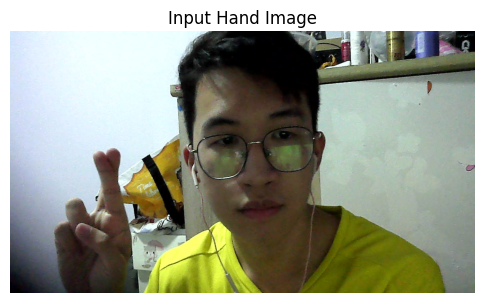

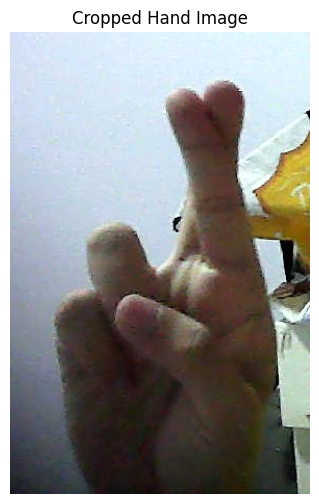

In [ ]:
example_image_path = '/content/dataset/unseen/DatasetKen/ร/RAO_RUEA_002.jpg'
if example_image_path:
    print(f"Testing with image: {example_image_path}")
    cropped_hand_image = crop_hand_from_image(example_image_path, margin=70)

    # Load the original image for display
    original_image = cv2.imread(example_image_path)
    if original_image is not None:
        original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(6, 6))
        plt.imshow(original_image_rgb)
        plt.title("Input Hand Image")
        plt.axis('off')
        plt.show()
    else:
        print(f"Error: Could not read original image from {example_image_path}")

    if cropped_hand_image is not None:
        cropped_hand_image_rgb = cv2.cvtColor(cropped_hand_image, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(6, 6))
        plt.imshow(cropped_hand_image_rgb)
        plt.title("Cropped Hand Image")
        plt.axis('off')
        plt.show()
    else:
        print("Failed to crop hand image.")
else:
    print("No example image found to test cropping.")

In [ ]:
def predict_hand_sign(image_np, model, class_names):
    if image_np is None:
        return "No image provided", 0.0

    # Convert BGR to RGB
    if len(image_np.shape) == 3 and image_np.shape[2] == 3:
        image_rgb = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)
    else:
        image_rgb = image_np

    # Resize image
    img_resized = cv2.resize(image_rgb, (224, 224))

    # Normalize
    img_normalized = img_resized.astype(np.float32) / 255.0
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_normalized = (img_normalized - mean) / std

    # Add batch dimension
    img_batch = np.expand_dims(img_normalized, axis=0)

    # Make prediction
    prediction = model.predict(img_batch, verbose=0)
    predicted_idx = np.argmax(prediction[0])
    confidence = prediction[0][predicted_idx]

    predicted_label = class_names[predicted_idx]
    return predicted_label, confidence

thai_mapping = {
    'bor': 'บ',
    'dor': 'ด',
    'for': 'ฟ',
    'hor': 'ห',
    'ko': 'ก',
    'lor': 'ล',
    'mor': 'ม',
    'nor': 'น',
    'or': 'อ',
    'por': 'ป',
    'rao': 'ร',
    'sor': 'ส',
    'tor': 'ต',
    'wor': 'ว',
    'yor': 'ย'
}

if 'cropped_hand_image' in locals() and cropped_hand_image is not None:
    predicted_label, confidence = predict_hand_sign(
        cropped_hand_image, model, class_names
    )

    thai_character = thai_mapping.get(predicted_label, predicted_label)

    print(f"Predicted hand sign: {predicted_label} ({thai_character}) with confidence: {confidence:.4f}")
else:
    print("Error: 'cropped_hand_image' is not available. Please run the previous cell to crop an image.")

Predicted hand sign: rao (ร) with confidence: 0.8274
